# A friendly Introduction to Backpropagation in Python

My aim here is to test my understanding of Karpathy's great blog post ["Hacker's guide to Neural Networks"](http://karpathy.github.io/neuralnets/) as well as of Python, to get a hang of which I recently perused through [Derek](http://www.newthinktank.com/2016/07/learn-program-9/) [Banas'](http://www.newthinktank.com/2016/07/learn-program-10/) [awesome](http://www.newthinktank.com/2016/07/learn-program-11/) [commented](http://www.newthinktank.com/2016/07/learn-program-12/) [code](http://www.newthinktank.com/2016/07/learn-program-13/) [expositions](http://www.newthinktank.com/2016/08/learn-program-15/). As someone steeped in R and classical statistical learning methods for structured data, I'm very new to both Python as well as Neural nets, so it is best not to fall into the easy delusions of competence that stem from being able to follow things while reading about them. Therefore, code.


### Neural Gates

One way to understand any node of a neural network is as a gate, which takes in one or more inputs, and produces an output, just like a function.

For example, consider a gate that takes in x and y, and computes:

Let's implement such a gate in Python:

In [24]:
def forwardMultiplyGate(x,y):
    return(x*y)
forwardMultiplyGate(-2, 3)

-6

Similarly, we can have a gate that computes the sum of its two inputs.

In [25]:
def forwardAddGate(x,y):
    return(x+y)
forwardAddGate(-2,3)

1

And a gate that computes the max of its two inputs

In [6]:
def forwardMaxGate(x, y):
    return(max(x,y))
forwardMaxGate(2,3)

3

### The Optimization Problem

Think of the goal of the circuit as to maximize the output. This is the optimization problem for the neural network (actually it is to minimize the loss function, but the difference is trivial for that's the same as maximizing the negative of loss function). Now it becomes crucial to identify how to modify the inputs a little bit, to make the output a little larger. If we are able to devise a method to identify that, we can try that method again and again to get successively larger values of the output, until we hit a wall and the output ceases to increase. At that point, we will say that we have maximized the output, at least locally.

#### Illustration with a simple circuit with just one gate, the forwardMultiplyGate

Suppose that the forwardMultiplyGate defined earlier is the only gate in our neural network. How we want to tweak each input depends on the output's sensitivity (or response) to changes in that input. Since the output is essentially a function of the inputs as shown before, the sensitivity of the output to each of the inputs is just the partial derivative with respect to that input, let us compute that:

In [7]:
# custom exception if user enters a 'wrt' argument different from x or y
class InvalidWRTargError(Exception):
    def __init__(self, *args, **kwargs):
        Exception.__init__(self, *args, **kwargs)

# write a function that numerically computes the partial derivative
# for a gate defined by function 'func', w.r.t a given input 'wrt'

# assume multiplicative gate if gate function not specified

def getNumericalForwardGradient(x, y, wrt, func=forwardMultiplyGate):
    initial=func(x,y)
    h=0.0001
    try:
        if wrt==x:
            final=func(x+h, y)
        elif wrt==y:
            final=func(x,y+h)
        else:
            raise InvalidWRTargError
    except InvalidWRTargError:
        return("third argument (wrt) should equal one of the inputs (first 2 arguments)")
    return((final-initial)/h)

In [8]:
getNumericalForwardGradient(3, 4, wrt=3, func=forwardMultiplyGate)

4.000000000008441

The gradient of the multiplicative gate with respect to x, when x=3 and y=4, equals 4, as expected, since del(xy)/del(x) = y, which is 4.

Since the gradient is positive, increasing x a little bit should increase the output. Let's check:

In [9]:
forwardMultiplyGate(3, 4)

12

In [10]:
forwardMultiplyGate(3.01, 4)

12.04

Just as we expected, the output increased.

This was a simple gate. But what if the gate implements the function f(x) where :

In [12]:
def forwardCustomGate(x,y):
    return(100-(x-y)**2)

If we provide 3 and 4 to such a gate, it should try to bring x and y closer together such that the output is maximized. It's trivial to see that this function is maximized at x=y

See the following for a visual aid:

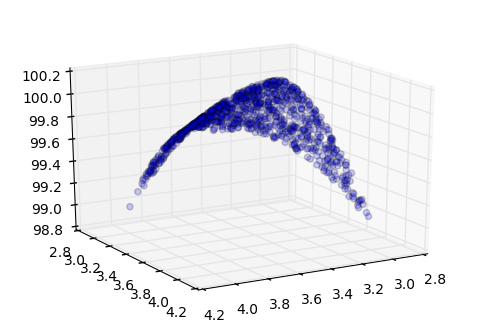

In [14]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs=3+np.random.rand(1000)
ys=3+np.random.rand(1000)
ax.scatter(xs, ys, forwardCustomGate(xs, ys), alpha=0.2)
ax.view_init(elev=20, azim=60)

Now let's define this gate and see whether our method of computing gradients and modifying inputs helps in increasing the output of this gate.

In [15]:
def applyGradientOnce(x, y, func, step_size):
    initial = func(x, y)
    gradient_wrt_x=getNumericalForwardGradient(x,y,x, func)
    gradient_wrt_y=getNumericalForwardGradient(x,y,y, func)
    x = x + gradient_wrt_x*step_size
    y = y + gradient_wrt_y*step_size
    final=func(x,y)
    return(final)

In [16]:
forwardCustomGate(3,4)

99

In [17]:
applyGradientOnce(3, 4, forwardCustomGate, 0.001)

99.00798399999998

As expected, modifying the inputs a little bit in the direction implied by the gradients results in a higher output. Now let's do this many, many times until the improvement or increase in the output is not significant anymore.

In [18]:
# recursive program for optimizing a binary function via gradient descent
def optimizeBinaryFunction(x, y, func, step_size):
    previous_val=func(x,y)
    gradient_wrt_x=getNumericalForwardGradient(x,y,x, func)
    gradient_wrt_y=getNumericalForwardGradient(x,y,y, func)
    x = x + gradient_wrt_x*step_size
    y = y + gradient_wrt_y*step_size
    new_val=func(x,y)
    if new_val-previous_val<0.000005:
        return([previous_val, x, y])
    else:
        return(optimizeBinaryFunction(x, y, func, step_size))

In [19]:
optimizeBinaryFunction(3, 4, forwardCustomGate, step_size=0.001)

[99.99937812746526, 3.487488988616036, 3.512326611377091]

As expected, optimizing in this way brought x from <b>3</b> to <b>3.49</b> and y from <b>4</b> to <b>3.51</b>, to maximize the output at <b>99.999</b>.

### Using analytical gradients

So far, we have demonstrated an application of the <b>gradient descent</b> method to optimize a single function by calculating gradients numerically via the getNumericalForwardGradient function. In practice, neural networks contain a large number of complex gates such that numerically computing the gradients every time becomes very expensive. Therefore, we often use analytical gradients, which are more accurate and computationally less demanding. 

This raises the question: what if the expression is complicated such that the analytical solution for the gradient is hard to mathematically solve for. We will see that to deal with such situations, we can get away with computing the analytical gradient for some simple expressions and then applying the <b>chain rule.</b>

## Circuits with multiple neural gates

Let's consider a gate that takes x, y, and z as inputs and outputs :

In fact, this is a essentially combination of two simple gates: an addition gate that takes in x and y, and a multiplication gate that takes in r and the output of the addition gate, say q. We can define this gate as follows:

In [26]:
def forwardCircuit(x, y, z):
    return(forwardMultiplyGate(forwardAddGate(x,y),z))

forwardCircuit(-2, 5, -4)

-12

![displaycircuit](img/aa.png)

Image above has been taken from http://karpathy.github.io/neuralnets/

## Backpropagation

Optimizing this circuit would require us to compute the gradient for the entire circuit. Instead, we will compute the gradient for each of the component gates and then apply chain rule to get the gradient for the entire circuit.

\begin{equation}q(x, y)= x + y \end{equation}

\begin{equation}
\frac{\partial q}{\partial x} = 1
\end{equation}

\begin{equation}
\frac{\partial q}{\partial y} = 1
\end{equation}


\begin{equation}
\frac{\partial f}{\partial q} = z
\end{equation}

\begin{equation}
------------------------
\end{equation}

\begin{equation}
\frac{\partial f}{\partial z} = x+y
\end{equation}


\begin{equation}
\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q}.\frac{\partial q}{\partial x} = z.1 = z
\end{equation}

\begin{equation}
\frac{\partial f}{\partial y} = \frac{\partial f}{\partial q}.\frac{\partial q}{\partial y} = z.1 = z
\end{equation}

Here, q is just a forwardAddGate with inputs x and y, and f is a forwardMultiplyGate with inputs z and q. The last two equations above are key: when calculating the gradient of the entire circuit with respect to x (or y) we merely calculate the gradient of the gate q with respect to x (or y) and magnify it by a factor equal to the gradient of the circuit with respect to the output of gate q.

For inputs to this circuit <b>x=-2, y=5, z=-4</b> it is straightforward to compute that $\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q}.\frac{\partial q}{\partial x} = z.1 = -4*1 = -4$

Let's see what's going on here. As such $\frac{\partial q}{\partial x}$ equals 1, i.e, increasing x increases the output of gate q. However, in the larger circuit (f) the output is increased by a reduction in the output of q, since $\frac{\partial f}{\partial q} = z = -4$ is a negative number. Hence, the goal, which is to maximize its output of the larger circuit f, is served by reducing q, for which x needs to be reduced.

Hopefully, it is clear now that in this circuit, to calculate the gradient with respect to any input, we need to just calculate the gradient for the simpler gate which directly takes that input, with respect to that input; and then multiply the result obtained with the gradient of the circuit with respect to that gate (chain rule). 

<i>But in a more complex circuit, that gate might lead into multiple other gates before the output stage, so it is best to do the chain computation backwards, starting from the output stage. (<b>Backpropagation</b>)</i>


![showgradient](img/bb.png)

Image above has been taken from http://karpathy.github.io/neuralnets/


Seeing as how we can use the chain rule, we may focus now on local gradients for some simple gates:

When $f(x,y)=max(x,y)$ ; $\frac{\partial f}{\partial x} = logical(x>y)$ and $\frac{\partial f}{\partial y} = logical(y>x)$


When $f(x,y)= x + y $ ; $\frac{\partial f}{\partial x} = \frac{\partial f}{\partial y}  = 1 $

When $f(x,y)= x * y $ ; $\frac{\partial f}{\partial x} = y $ and $\frac{\partial f}{\partial y} = x $

I just realized we haven't coded in a while. Oops. Now we will code all that we discussed and see how backpropagation helps us calculate the same gradient using the chain rule.

In [21]:
class Unit:
    
    def __init__(self, value, grad):
        self.value=value
        self.grad=grad

class MultiplyGate:
        """
        Attributes not in constructor:
        input1: first gate that inputs into the multiply gate
        input2: second gate that inputs into the multiply gate
        output: the output version of the gate that goes as input elsewhere
        """
        
        def forward(self, input1, input2): #input1,input2 are also Units
            # store pointers to input gates:
            self.input1=input1
            self.input2=input2
            self.output=Unit(input1.value*input2.value, 0.0)
            return(self.output)
            
        #take the gradient in output and chain it with local gradients    
        def backward(self):
            self.input1.grad += self.input2.value * self.output.grad 
            self.input2.grad += self.input1.value * self.output.grad 

class AddGate:
           
        def forward(self, input1, input2):
            self.input1=input1
            self.input2=input2
            self.output=Unit(input1.value+input2.value, 0.0)
            return(self.output)
            
        def backward(self):
            self.input1.grad += 1 * self.output.grad 
            self.input2.grad += 1 * self.output.grad 
            
class SigmoidGate:
           
        def forward(self, input1):
            self.input1=input1
            self.output=Unit(1/(1+exp(-input1.value)), 0.0)
            return(self.output)
            
        def backward(self):
            self.input1.grad += (self.output.value*(1-self.output.value)) * self.output.grad 

Having defined the gates and units, let us run the forward pass to generate output values:

In [20]:
# Forward Pass

x=Unit(-2,0)
y=Unit(5,0)
z=Unit(-4,0)

a=AddGate()
q=a.forward(x,y)

m=MultiplyGate()
f=m.forward(q,z)

print(f.value) #should come out to (-2 + 5)*-4 , i.e., -12

-12


Now let us run the backward pass to decipher the gradient df/dx:

In [18]:
# Backward Pass

f.grad=1
m.backward()
a.backward()
a.input1.grad

-4.0

So now we've implemented backprop from scratch for a simple circuit, and seen how to obtain gradients of a larger circuit with respect to individual inputs using the chain rule backwards. That was fun!